In [2]:
import torch
print(torch.__version__)
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from PIL import Image
import sys
from os.path import join
sys.path.append("../pytorch-unet-segmentation-master/src/")
from save_history import *
from modules import *
from dataset import *
import ipywidgets as widgets
import cv2
from tqdm.notebook import tqdm
from czifile import CziFile
import Funciones

1.5.0


Load Claudio data

In [3]:

with CziFile(join("../pytorch-unet-segmentation-master/test2/test2.czi")) as czi:
    image_arrays = czi.asarray()
    meta = czi.metadata(raw=False)

Create PNG images

In [4]:
import matplotlib.pyplot as plt
z=0
for x in range (0, 60):
    img = image_arrays[0, 0, 0, x, 0, :, :, 0]
    plt.imsave(join("../pytorch-unet-segmentation-master/Claudio_png", "test", str(x)+".png"), img, cmap='gray_r') #guarda en escala de grises invertido

In [6]:
r = c = 190
w = h = 388

model = torch.load('../pytorch-unet-segmentation-master/modelos/model_epoch_440.pwf', map_location=torch.device('cpu')).module.cpu()
model.eval()

original=[]
preprocesada=[]
for x in range (0, 60):
    i = cv2.imread('../pytorch-unet-segmentation-master/Claudio_png/test/'+str(x)+'.png', cv2.IMREAD_GRAYSCALE)[r:r+h, c:c+w]
    original.append(i)
    i_p= cv2.bilateralFilter(i, 5, 75, 75)
    i_p= cv2.equalizeHist(i_p)
    preprocesada.append(i_p)
    plt.imsave(join("../pytorch-unet-segmentation-master/preprocesada","test", str(x)+".png"), i_p, cmap='gray')

Text(0.5,1,'Preprocesada')

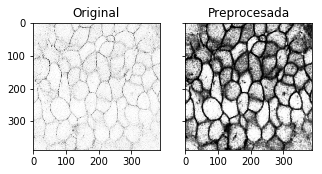

In [7]:
img_num=5
fig, ax = plt.subplots(1, 2, figsize=(5, 5), sharex=True, sharey=True)
ax[0].imshow(original[img_num], cmap=plt.cm.Greys_r)
ax[0].set_title('Original')
ax[1].imshow(preprocesada[img_num], cmap=plt.cm.Greys_r)
ax[1].set_title('Preprocesada')

## Torch dataset para las imágenes de Claudio

- El dataset lo creo con ImageFolder. Las imágenes deben estar en "Claudio_png/test"
- Le aplico transforms para llevarlo a escala de grises e imitar el crop/padding que se usaba nates
- Finalmente le aplico una transformación custom para "corregir la imagen"

> El objetivo es que las imágenes de Claudio se vean más parecidas a las del challenge

In [ ]:
import torchvision
import torchvision.transforms.functional as TF

# https://pytorch.org/docs/stable/torchvision/transforms.html
#equ = cv2.equalizeHist(img)
class ImproveImageTransform:
    
    def __init__(self, contrast_factor=1, brightness_factor=1, saturation_factor=1):
        self.saturation_factor= saturation_factor # 0 will give a black and white image,1 will give the original image while 2 will enhance the saturation by a factor of 2.
        self.contrast_factor = contrast_factor
        self.brightness_factor = brightness_factor

    def __call__(self, x):
        x = TF.adjust_gamma(x, gamma=1)
        x = TF.adjust_saturation(x, self.saturation_factor) 
        x = TF.adjust_brightness(x, self.brightness_factor)
        x = TF.adjust_contrast(x, self.contrast_factor)
        return x

my_transforms = torchvision.transforms.Compose([torchvision.transforms.Grayscale(),
                                                torchvision.transforms.Pad(padding=(572-388)//2,
                                                                           padding_mode='reflect'),
                                                torchvision.transforms.ToTensor()])
               
claudio_dataset = torchvision.datasets.ImageFolder("../pytorch-unet-segmentation-master/preprocesada", transform=my_transforms)

claudio_loader = torch.utils.data.DataLoader(dataset=claudio_dataset, batch_size=1, 
                                             num_workers=0, shuffle=False)

#Watersheed_img.watersheed_img(claudio_loader)
img_list = []
water_list = []
kernel = np.ones((1, 1), np.uint8)
kernel1 = np.ones((3, 3), np.uint8)
for image, label in tqdm(claudio_loader):
    with torch.no_grad():
        output = model.forward(image)
        output = torch.argmax(output, dim=1).float()
        img = output[0].detach().numpy().astype('uint8')*255
        img_list.append(img)
        ret, bin_image = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        closing = cv2.morphologyEx(bin_image, cv2.MORPH_CLOSE, kernel, iterations=1)
        sure_bg = cv2.dilate(closing, kernel1, iterations=1)
        dist_transform = cv2.distanceTransform(closing, cv2.DIST_L2, 5)
        ret, sure_fg = cv2.threshold(dist_transform, 0.2*dist_transform.max(), 255, 0)
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg, sure_fg)
        ret, markers = cv2.connectedComponents(sure_fg)
        markers_plus1 = markers + 1
        markers_plus1[unknown == 255] = 0
        watershed =  cv2.watershed(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), markers_plus1.copy())
        water_list.append(watershed)

%matplotlib notebook
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(9, 3), tight_layout=True)
pad = (572-388)//2
ax[0].imshow(image.numpy()[0, 0], cmap=plt.cm.Greys_r)
ax[1].imshow(output.numpy()[0], cmap=plt.cm.Greys_r)

borders_on_top = image.numpy()[0, 0, pad:-pad, pad:-pad].copy()
idx = np.where(output.numpy()[0].astype(int) == 0)
borders_on_top[idx[0], idx[1]] = 0
ax[2].imshow(borders_on_top, cmap=plt.cm.Greys_r)

<IPython.core.display.Javascript object>


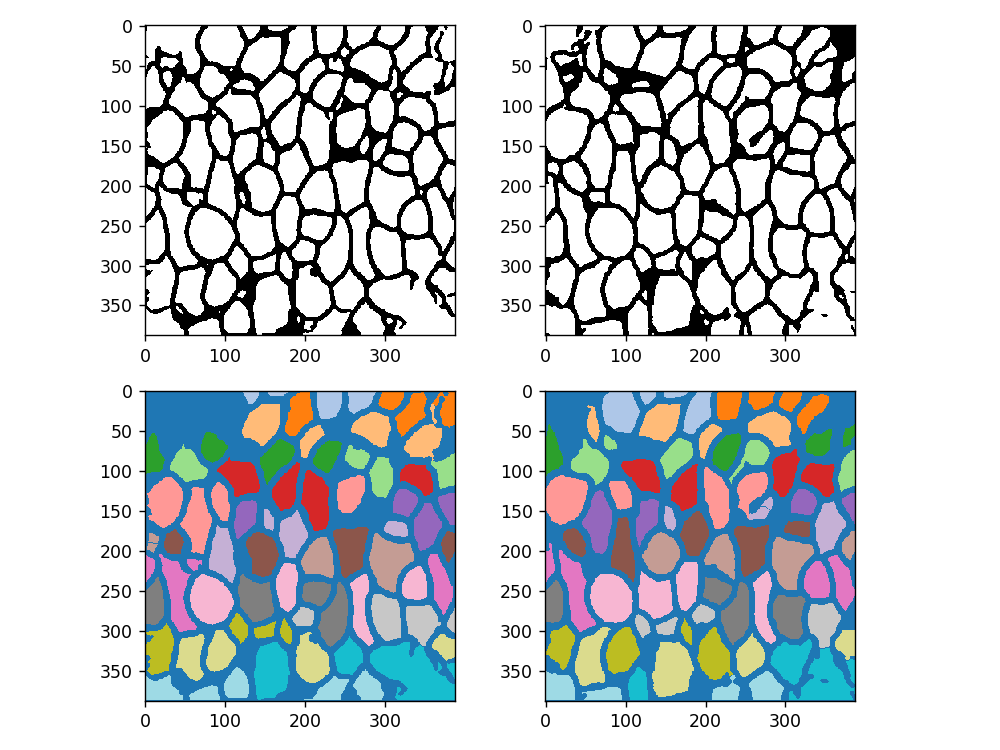

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), tight_layout=True)
ax[0, 0].imshow(img_list[0], cmap=plt.cm.Greys_r)
ax[1, 0].imshow(water_list[0], cmap=plt.cm.tab20)
ax[0, 1].imshow(img_list[58], cmap=plt.cm.Greys_r)
ax[1, 1].imshow(water_list[58], cmap=plt.cm.tab20)

<IPython.core.display.Javascript object>


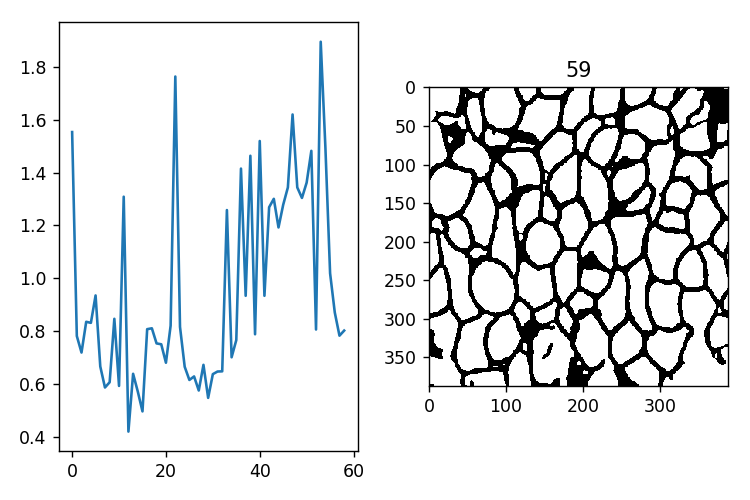

In [24]:
total_area = np.prod(watershed.shape)

cell_idx = 2
cell_coords = np.mean(np.where(water_list[0]==cell_idx), axis=1)
size_cell = []
cell_idx_history = [cell_idx]

for water in water_list[1:]:
    # Get coords of all cells
    new_cords = [np.mean(np.where(water==idx), axis=1) for idx in np.unique(water)[1:]]
    # Find nearest neightbor index
    closest_idx = np.argmin(np.sum((np.stack(new_cords) - cell_coords)**2, axis=1))
    
    #if distancias iguales, if celula desaparece, if distancia mayor a cierta cantidad de pixeles, 
    #medir distancia, if dos celulas se fusionan , if si dos tienen 2 celulas con misma next la que tenga menor
    nn_idx = np.unique(water)[1:][closest_idx]
    # Save index and area, agregar condiciones 
    cell_idx_history.append(nn_idx)
    size_cell.append(100*len(np.where(water == nn_idx)[0])/total_area)
    # update cell coords
    cell_coords = np.mean(np.where(water==nn_idx), axis=1)
    
#Adaptar visualizacion
# AGREGAR RESTRICCIONES #
#elimino los menores a 1
new_size_cell=[]
for size in size_cell:
    if (size<3):
        new_size_cell.append(size)
        
fig, ax = plt.subplots(1,2, figsize=(6, 4), tight_layout=True)
ax[0].plot(new_size_cell)

from matplotlib.animation import FuncAnimation

def update(k):
    ax[1].cla()
    img = img_list[k].copy()
    img[water_list[k]==cell_idx_history[k]] = 255
    ax[1].imshow(img, cmap=plt.cm.Greys_r)
    ax[1].set_title(k)
    
ani = FuncAnimation(fig, update, frames=range(60), repeat=False, interval=200)

In [25]:
len(new_size_cell)

59

<IPython.core.display.Javascript object>


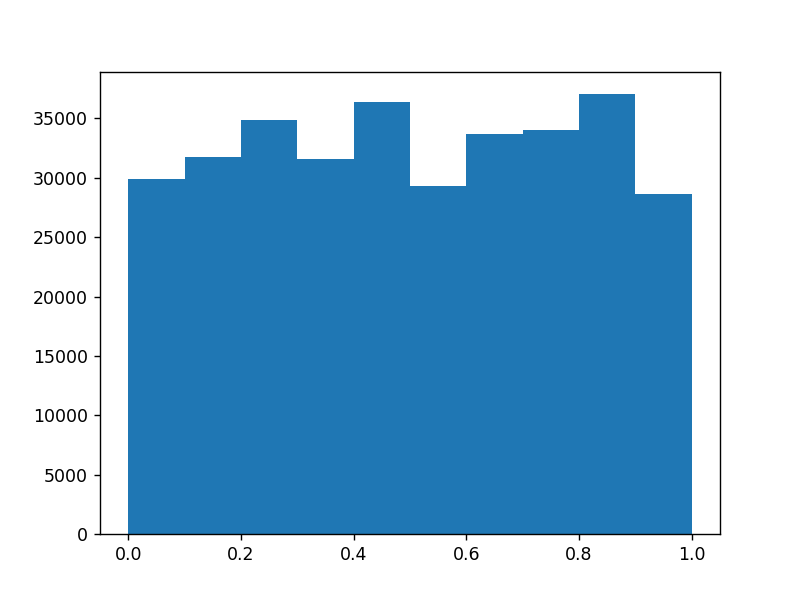

(array([29900., 31715., 34835., 31603., 36427., 29319., 33676., 34029.,
        37062., 28618.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

In [26]:
plt.figure()
plt.hist(image.numpy()[0, 0].ravel())